In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

**Data**: insurance company client characteristics

**Task**: you need to understand whether the client will be interested in insurance. Thus, the insurance company can target advertising more optimally and build communication with customers, increasing conversion.

**Column descriptions:**
- Gender - Male, Female
- Age - Age
- Driving_License - Availability of a driver's license
- Region_Code - Region of residence
- Previously_Insured - Have you used the services of an insurance company before?
- Vehicle_Age - Vehicle age
- Vehicle_Damage - Whether the vehicle was involved in an accident
- Annual_Premium - Client’s annual payments
- Policy_Sales_Channel - Policy for the distribution of insurance services (through intermediaries, directly, etc.)
- Vintage - Number of days during which the client was associated with the company


- **Response** - interested in insurance 1, did not respond 0

In [9]:
### Load data
data = pd.read_csv('vehicle_insurance.csv')

data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,24,1,37.0,1,< 1 Year,No,21243.0,152.0,21,0
9996,Male,28,1,35.0,1,< 1 Year,No,23589.0,160.0,173,0
9997,Female,27,1,15.0,0,< 1 Year,Yes,33340.0,152.0,207,0
9998,Female,28,1,14.0,1,< 1 Year,No,25426.0,152.0,247,0


Let's do a little EDA. Let's look at the distributions of some columns, at the correlation matrix. Let's also check the balance of classes and look at the distribution of vehicle age depending on response. \
Let's encode features of the `object` type using `one-hot` encoding.

P.S. Some non-object columns are obviously categorical in meaning. Since we will be building ensembles based on trees, they can be left in their original form.

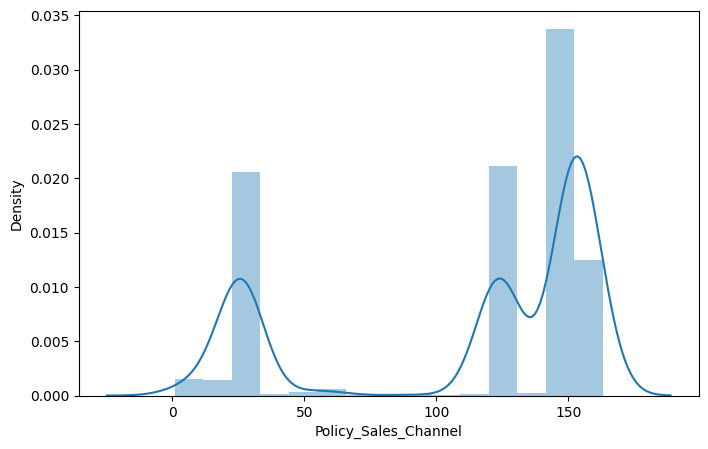

In [10]:
sns.distplot(data['Policy_Sales_Channel']);

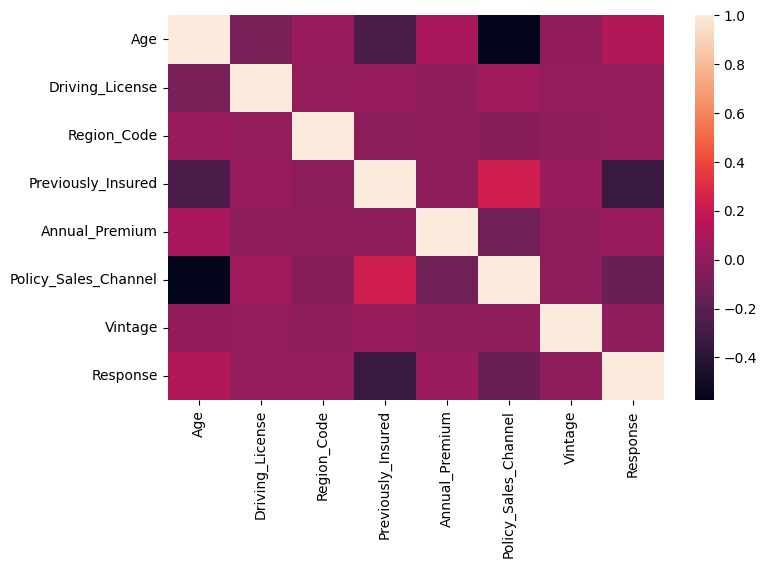

In [11]:
sns.heatmap(data.corr());

<Axes: xlabel='Vehicle_Age', ylabel='count'>

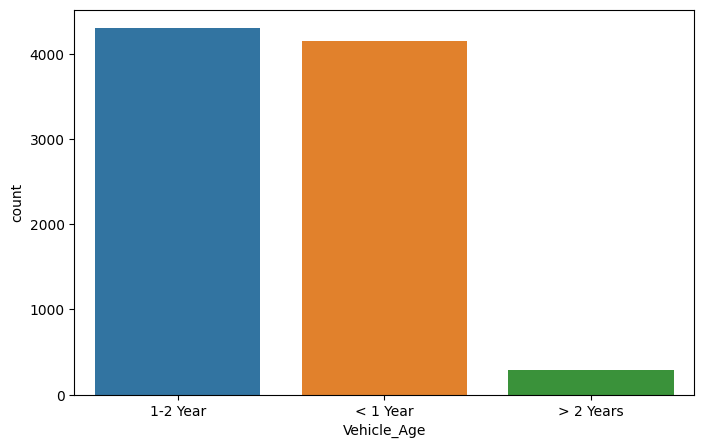

In [17]:
sns.countplot(data[data['Response'] == 0], x="Vehicle_Age")

<Axes: xlabel='Vehicle_Age', ylabel='count'>

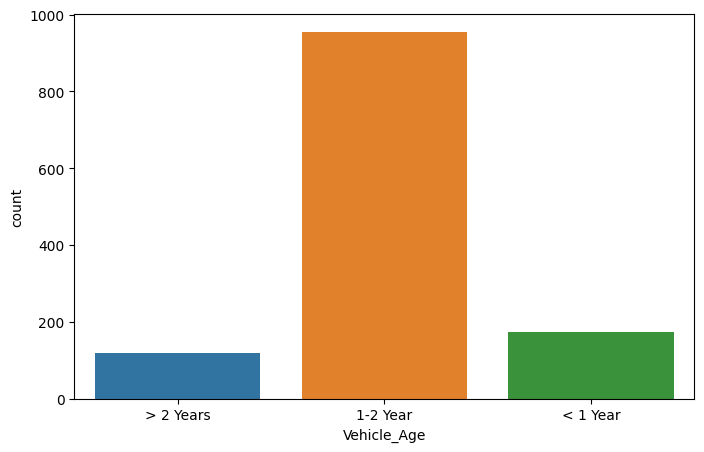

In [18]:
sns.countplot(data[data['Response'] == 1], x="Vehicle_Age")

In [19]:
data['Response'].value_counts(True)

0    0.8753
1    0.1247
Name: Response, dtype: float64

In [20]:
data_copy = data.copy()

In [21]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,44,1,28.0,0,40454.0,26.0,217,1,1,0,1,1
1,76,1,3.0,0,33536.0,26.0,183,0,1,0,0,0
2,47,1,28.0,0,38294.0,26.0,27,1,1,0,1,1
3,21,1,11.0,1,28619.0,152.0,203,0,1,1,0,0
4,29,1,41.0,1,27496.0,152.0,39,0,0,1,0,0


### GradientBoostingClassifier

Let's train gradient boosting from sklearn on data and measure accuracy and f1-score on a test sample. Set ensemble parameters to `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Let's plot the ROC curve, calculate the AUC, and evaluate the quality of classification.

In [22]:
### Train-test split
X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [23]:
model = GradientBoostingClassifier(learning_rate=1,
                                   n_estimators=100,
                                   random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1770
           1       0.31      0.24      0.27       230

    accuracy                           0.85      2000
   macro avg       0.61      0.59      0.59      2000
weighted avg       0.84      0.85      0.84      2000



Area under curve (AUC):  0.828168754605748


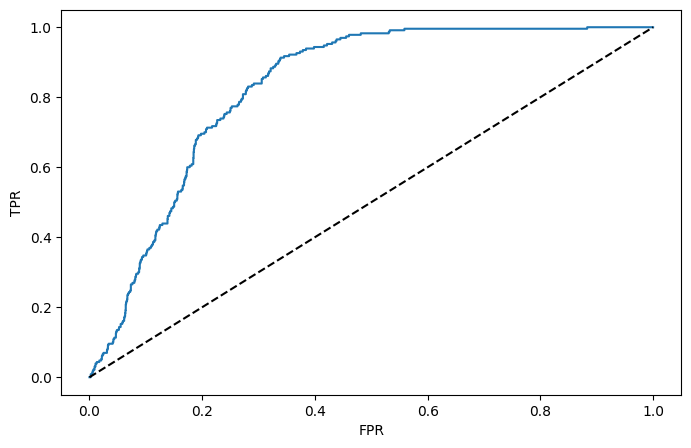

In [24]:
### ROC_curve, auc
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black');
print ('Area under curve (AUC): ', auc(fpr, tpr))

Let's go through the `n_estimators` and `learning_rate` parameters over a two-dimensional grid.

Let's construct curves for the f1-score metric depending on the number of steps for several learning_rates. Let's draw a heatmap of the resulting matrix.

P.S. To calculate f1-score, set the `average='weighted'` parameter so that class balance is also taken into account.

In [25]:
# Setting up a grid of parameters
n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]

f1_matrix = np.zeros((len(n_estimators_list), len(learning_rate_list)))

for (i, n) in enumerate(n_estimators_list):
    for (j, lr) in enumerate(learning_rate_list):
        model = GradientBoostingClassifier(n_estimators=n,
                                           learning_rate=lr,
                                           max_depth=5,
                                           random_state=1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        f1_matrix[i, j] = f1_score(y_test, y_pred, average='weighted')
        
print(f1_matrix)

f1_dataframe = pd.DataFrame(f1_matrix, 
                            index=map(str, n_estimators_list), 
                            columns=map(str, learning_rate_list))

[[0.83598325 0.83197068 0.83100796]
 [0.83840034 0.83197068 0.83100796]
 [0.84418229 0.83171715 0.83100796]
 [0.83673899 0.83162689 0.83222411]
 [0.83816464 0.83772792 0.83197068]
 [0.842608   0.84312432 0.83171715]
 [0.84469897 0.84268016 0.8348982 ]
 [0.84609732 0.84572434 0.83711097]]


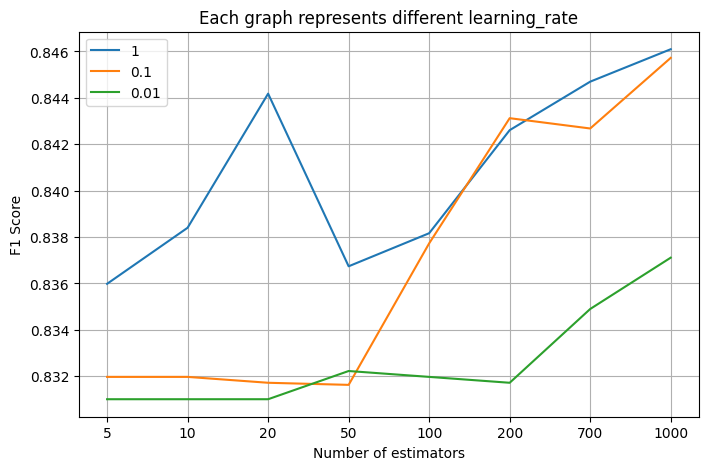

In [26]:
### Training curves
plt.plot(f1_dataframe)

plt.title('Each graph represents different learning_rate')
plt.xlabel('Number of estimators')
plt.ylabel('F1 Score')

plt.grid()
plt.legend(learning_rate_list);

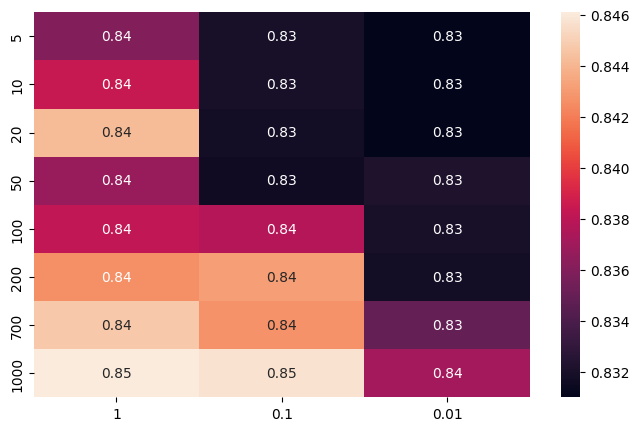

In [27]:
### Heatmap
sns.heatmap(f1_dataframe, annot=True);

the higher f-1 the more efficient the model

In [28]:
model = GradientBoostingClassifier(learning_rate=1,
                                   n_estimators=1000,
                                   random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9049    0.9249    0.9148      1770
           1     0.3037    0.2522    0.2755       230

    accuracy                         0.8475      2000
   macro avg     0.6043    0.5885    0.5952      2000
weighted avg     0.8358    0.8475    0.8413      2000



### RandomForestClassifier vs GradientBoostingClassifier

Let's train 4 models and calculate the f1-score metric on the test and training samples for each model.
1. Random forest with a maximum tree depth of 5,
2. Random forest with a maximum tree depth of 5000,
3. Gradient boosting with a maximum tree depth of 5.
4. Gradient boosting with a maximum tree depth of 5000.

In [30]:
### Try different models
n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]
f1_matrix = np.zeros((len(n_estimators_list), 8))

for (j, max_depth) in enumerate([5, 5000]):
    for (i, n) in enumerate(n_estimators_list):

        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    random_state=1)
        rf.fit(X_train, y_train)
        rf_pred_test, rf_pred_train = rf.predict(X_test), rf.predict(X_train)

        lgb = GradientBoostingClassifier(n_estimators=n,
                                         max_depth=max_depth,
                                         random_state=1)
        lgb.fit(X_train, y_train)
        lgb_pred_test, lgb_pred_train = lgb.predict(X_test), lgb.predict(X_train)
        
        f1_matrix[i, j*4:j*4+4] = (f1_score(y_test, rf_pred_test, average='weighted'),
                                   f1_score(y_train, rf_pred_train, average='weighted'),
                                   f1_score(y_test, lgb_pred_test, average='weighted'),
                                   f1_score(y_train, lgb_pred_train, average='weighted'))
        
trees = list(map(str, n_estimators_list))

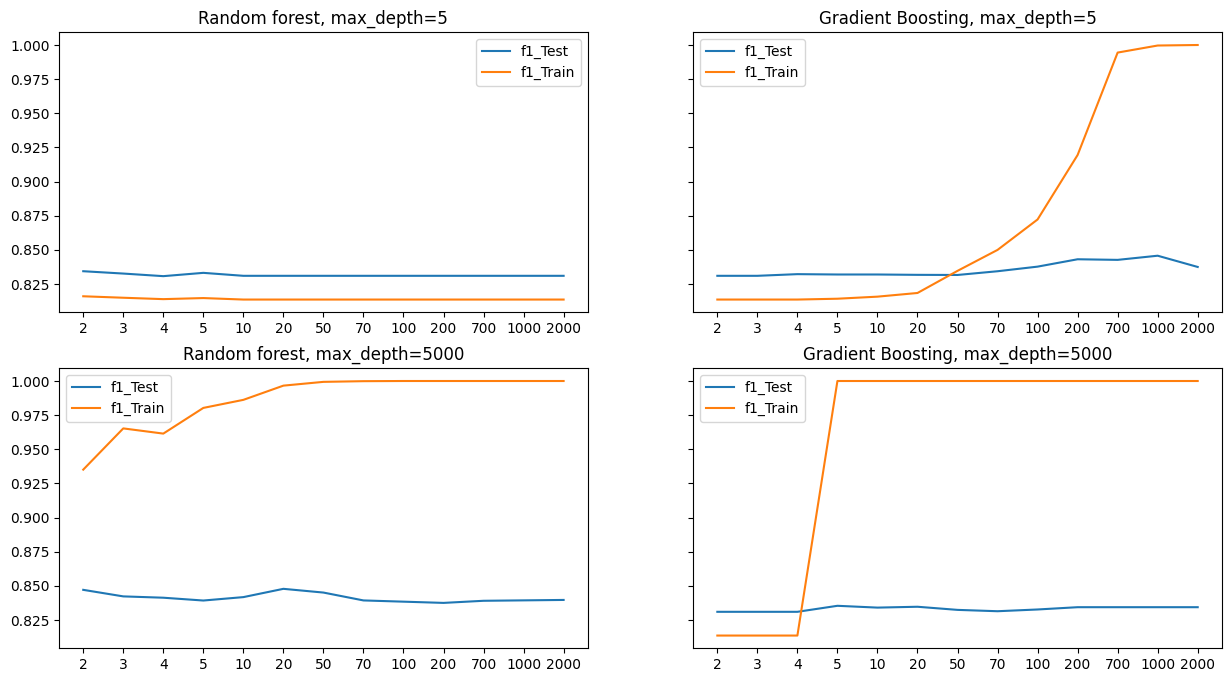

In [31]:
### Plot training curves

fig, axs = plt.subplots(2, 2, figsize = (15, 8), sharey=True)

for (i, ax) in enumerate(axs.reshape(-1)):
    ax.plot(trees, f1_matrix[:, i*2], label = 'f1_Test')
    ax.plot(trees, f1_matrix[:, i*2+1], label = 'f1_Train')
    ax.legend()
    
axs[0, 0].set_title('Random forest, max_depth=5')
axs[1, 0].set_title('Random forest, max_depth=5000')

axs[0, 1].set_title('Gradient Boosting, max_depth=5')
axs[1, 1].set_title('Gradient Boosting, max_depth=5000');

### Feature Importance GradientBoostingClassifier vs CatBoostClassifier

In [32]:
X = data_copy.drop('Response', axis=1)
y = data_copy['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

cboost = CatBoostClassifier(verbose=0)

cboost.fit(X_train,
           y_train,
           cat_features=['Gender', 'Vehicle_Age', 'Vehicle_Damage'])

y_pred = cboost.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8891    0.9870    0.9355      1770
           1     0.3429    0.0522    0.0906       230

    accuracy                         0.8795      2000
   macro avg     0.6160    0.5196    0.5130      2000
weighted avg     0.8262    0.8795    0.8383      2000



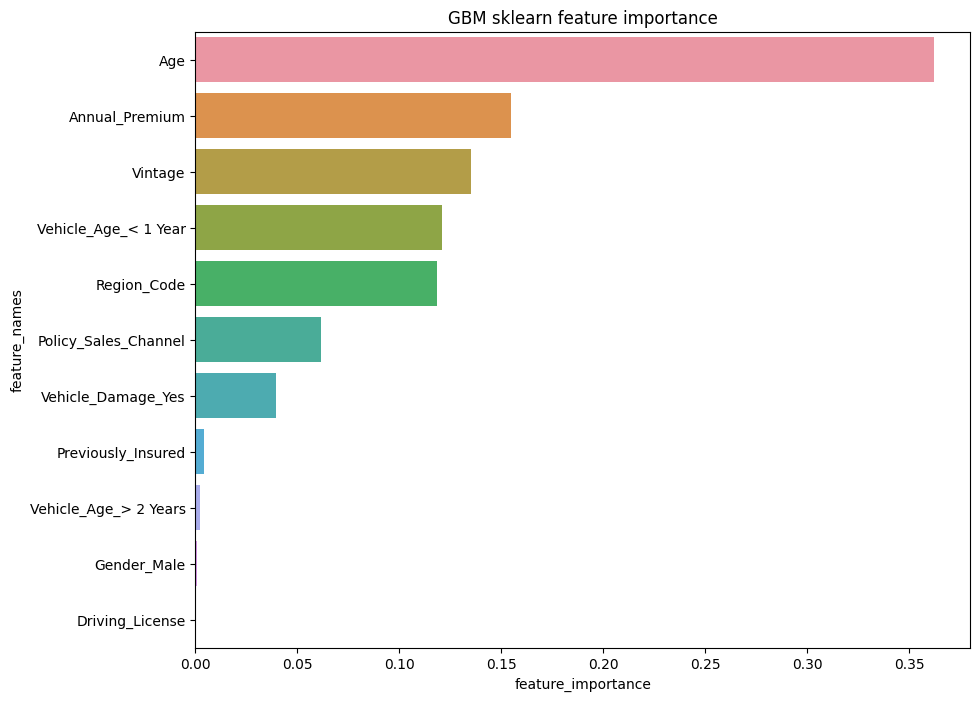

In [33]:
### What features are most important in the model for GradientBoostingClassifier
fi_df = pd.DataFrame({'feature_names': data.columns.drop('Response'),
                      'feature_importance': model.feature_importances_})

plt.figure(figsize=(10,8))
sns.barplot(x='feature_importance', y='feature_names', 
            data=fi_df.sort_values('feature_importance', ascending=False))
plt.title('GBM sklearn feature importance');

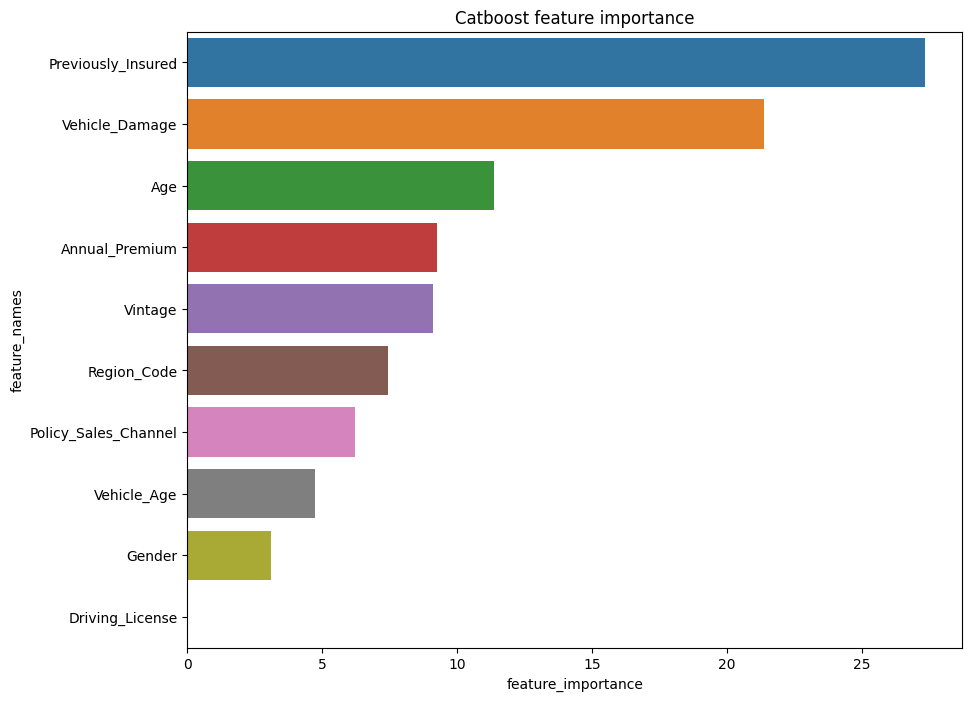

In [34]:
### What features are most important in the model for CatBoostClassifier

fi_df = pd.DataFrame({'feature_names': data_copy.columns.drop('Response'),
                      'feature_importance': cboost.get_feature_importance()})

plt.figure(figsize=(10,8))
sns.barplot(x='feature_importance', y='feature_names', 
            data=fi_df.sort_values('feature_importance', ascending=False))
plt.title('Catboost feature importance');

### LGBMClassifier

`lightgbm` - Today this is the fastest method of gradient boosting, while consuming a small amount of RAM. It achieves this by building trees in depth by leaves (leaf-wise), and not by levels (level-wise), like other methods, for example XGBoost.

While XGBoost splits vertices at an entire level of the same depth at a time, LightGBM splits one vertex at a time. Hence the increase in speed.

In [35]:
X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

#%%time
params = {'n_estimators': [100, 500, 1000, 2000],
          'max_depth': [2, 3, 5, 100],
          'learning_rate': [0.1, 0.01, 0.001]}

grid = GridSearchCV(LGBMClassifier(), params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8850    1.0000    0.9390      1770
           1     0.0000    0.0000    0.0000       230

    accuracy                         0.8850      2000
   macro avg     0.4425    0.5000    0.4695      2000
weighted avg     0.7832    0.8850    0.8310      2000



In [36]:
grid.best_estimator_

LGBMClassifier(learning_rate=0.01, max_depth=2)

### KNeighborsClassifier

Let's try to speed up the work of kNN using clustering without losing much quality

In [37]:
### train-test split

X = data.drop('Response', axis=1)[:25000]
y = data['Response'][:25000]

X_train, X_test, y_train, y_test = train_test_split(X, y.values,
                                                    random_state=0,
                                                    test_size=0.2)

X_train.shape, X_test.shape

((8000, 11), (2000, 11))

In [38]:
### data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Let's train a regular kNN with one neighbor and measure the quality, for example, a weighted f-measure, so that we can then compare it with our implementation.

In [39]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [40]:
%%time
y_pred = knn.predict(X_test)

CPU times: user 291 ms, sys: 5.64 ms, total: 297 ms
Wall time: 334 ms


In [41]:
print(f1_score(y_test, y_pred, average='weighted'))

0.8258057146080727


Let's speed up kNN!

Algorithm(Product Quantization):

- Divide the training and test samples into blocks: evenly along the column indices.
- On each block, train K-Means and apply transform accordingly. control sample block.
- Calculate the distances from each training object to each object from the control sample
- For each test object, determine the k closest

In [42]:
def product_quantization(X_train, X_test, m_blocks=5, n_clusters=100):
    dist_table = np.zeros([X_test.shape[0], n_clusters, m_blocks])
    X_train_clusters = np.zeros([X_train.shape[0], m_blocks])
    
    for i in range(m_blocks):
        ### Let's cut out a block from the training and test samples
        block_size = X_test.shape[1] // m_blocks
        X_train_block = X_train[:, i*block_size:(i+1)*block_size].copy()
        X_test_block = X_test[:, i*block_size:(i+1)*block_size].copy()
        
        ### K-Means 
        ### Let's put the calculated distances to the centers in the dist_table matrix
        kmeans = KMeans(n_clusters=n_clusters).fit(X_train_block)
        dist_table[:, :, i] = kmeans.transform(X_test_block)
        
        ### Let's put the cluster labels in the X_train_clusters matrix
        X_train_clusters[:, i] = kmeans.predict(X_train_block)
        
    return X_train_clusters, dist_table

In [43]:
%%time
X_train_clusters, dist_table = product_quantization(X_train, X_test, 
                                                    m_blocks=5, 
                                                    n_clusters=100)

CPU times: user 12.8 s, sys: 1.86 s, total: 14.6 s
Wall time: 6.59 s


- Now, using the resulting tables, it remains to calculate the distances to each object in the training sample.
- First, let's square dist_table to get the sum of squares, not the l2 norm.
- For each block, using the predicted class labels in X_train_clusters, select the corresponding distances from dist_table
- Let's sum up the squared distances across all blocks.
- Let’s find the indices of the shortest distances and use them to select objects from y_train, these will be our predictions

In [44]:
sumsq_table = dist_table ** 2
sumsq_table.shape

X_train_clusters = X_train_clusters.astype('int')

In [45]:
%%time
distances = np.zeros([sumsq_table.shape[0], X_train.shape[0]])
m_blocks = 5

for b in range(m_blocks):
    distances += sumsq_table[:, X_train_clusters[:, b], b]

y_pred = y_train[np.argmin(distances, axis=1)]

CPU times: user 2.29 s, sys: 296 ms, total: 2.58 s
Wall time: 2.89 s


In [46]:
print(f1_score(y_test, y_pred, average='weighted'))

0.8215205011389523
